In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random
import math
import matplotlib.pyplot as plt
import numpy as np

### Select Device

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Define Model

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, nhead, nhid, nlayers, output_dim, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.embed_dim = embed_dim
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        self.encoder = nn.Embedding(input_dim, embed_dim)
        self.transformer = nn.Transformer(embed_dim, nhead, nlayers, nlayers, nhid, dropout)
        self.decoder = nn.Linear(embed_dim, output_dim)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, src, src_mask):
        src = src
        src = self.encoder(src) * math.sqrt(self.embed_dim)
        src = self.pos_encoder(src)
        output = self.transformer(src, src, src_mask)
        output = self.decoder(output)
        return output

### Process Data

In [25]:
all_chars = string.printable
n_chars = len(all_chars)
file = open('../Data/shakespeare.txt').read()
file_len = len(file)

In [26]:
def get_random_seq():
    seq_len = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index = start_index + seq_len + 1
    return file[start_index:end_index]

def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), n_chars, dtype=torch.long)
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][index] = 1.0
    return tensor

def seq_to_index(seq):
    tensor = torch.zeros(len(seq), dtype=torch.long)
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

def get_input_and_target():
    seq = get_random_seq()
    input = seq_to_index(seq[:-1])  # Input is represented in index.
    target = seq_to_index(seq[1:])  # Target is represented in index.
    return input, target

def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
    return mask

### Text Generation

In [27]:
# def generate_text(model, start_seq='W', max_len=100):
#     model.eval()
#     with torch.no_grad():
#         input = seq_to_index(start_seq).unsqueeze(1)  # Shape: (seq_len, batch_size=1)
#         generated = input.to(device)

#         for _ in range(max_len):
#             src_mask = generate_square_subsequent_mask(generated.size(0)).to(device)
#             output = model(generated, src_mask)
            
#             # Select the last time step's output
#             next_char_logits = output[-1, 0, :]
#             next_char = torch.argmax(next_char_logits, dim=-1).unsqueeze(0).unsqueeze(1)  # Shape: (1, 1)
            
#             generated = torch.cat((generated, next_char), dim=0)  # Concatenate along the sequence dimension

#         generated_seq = ''.join([all_chars[idx] for idx in generated.squeeze().tolist()])
#     return generated_seq
# gpt
# def generate_text(model, start_seq='W', max_len=100):
#     predicted_seq = start_seq
# #     model.eval()
# #     with torch.no_grad():
#     init_input = seq_to_index(start_seq).to(device)
#     input = init_input[-1]  # Shape: (seq_len, batch_size=1)
#     for _ in range(max_len):
#         src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
#         output = model(input, src_mask)
#         predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]

#         # Add predicted character to the sequence and use it as next input.
#         predicted_char  = all_chars[predicted_index]
#         predicted_seq  += predicted_char

#         # Use the predicted character to generate the input of next round.
#         input = seq_to_index(predicted_char)[0].to(device)
#     return predicted_seq


# Evaluation step function.
# def generate_text(model, init_seq='W', predicted_len=100):
 
#     init_input    = seq_to_onehot(init_seq).to(device)
#     predicted_seq = init_seq

#     # Set current input as the last character of the initial string.
#     input = init_input[-1]
    
#     # Predict more characters after the initial string.
#     for t in range(predicted_len):
#         src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
#         output = model(input, src_mask)
        
#         # Sample from the output as a multinomial distribution.
#         output = output.view(-1, output_dim)
#         print(output.shape)
#         predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
#         print(predicted_index)
        
#         # Add predicted character to the sequence and use it as next input.
#         predicted_char  = all_chars[predicted_index]
#         predicted_seq  += predicted_char
        
#         # Use the predicted character to generate the input of next round.
#         input = seq_to_onehot(predicted_char)[0].to(device)

#     return predicted_seq

In [28]:
def generate_text(model, start_seq='W', gen_len=100):
    model.eval()  # Set the model to evaluation mode
    
    # Convert the starting sequence to indices
#     init_input = seq_to_index(start_seq).unsqueeze(1).to(device)
    input_seq = seq_to_index(start_seq).unsqueeze(1).to(device)  # Add batch dimension, shape: (seq_len, 1)
    
    generated_text = start_seq
    
    for _ in range(gen_len):
        src_mask = generate_square_subsequent_mask(input_seq.size(0)).to(device)
        with torch.no_grad():
            output = model(input_seq, src_mask)
        
        # Get the last output and convert to probabilities
        next_char_logits = output[-1, 0, :]  # Shape: (output_dim)
        next_char_probs = torch.softmax(next_char_logits, dim=-1)
        
        # Sample the next character
#         next_char_index = np.random.choice(len(all_chars), p=next_char_probs)
        predicted_char_index = torch.argmax(next_char_probs)
        next_char = all_chars[predicted_char_index]
        
        generated_text += next_char
        
        # Append the next character to the input sequence
        next_char_tensor = torch.tensor([predicted_char_index], dtype=torch.long).unsqueeze(1).to(device)
        input_seq = torch.cat([input_seq, next_char_tensor], dim=0)
    
    return generated_text


In [29]:
input_dim = 512
embed_dim = 128
nhead = 2
nhid = 256
nlayers = 2
output_dim = len(all_chars)
dropout = 0.2

model = TransformerModel(input_dim, embed_dim, nhead, nhid, nlayers, output_dim, dropout)
model.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): Embedding(512, 128)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDe

### Training Cell

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
iters = 100
all_losses = []
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0.
    for _ in range(iters):  # Adjust the number of batches
        input, target = get_input_and_target()
        # Add batch dimension, shape: (seq_len, batch_size=1)
        input = input.unsqueeze(1).to(device)
        target = target.unsqueeze(1).to(device)
     
        src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
        
        optimizer.zero_grad()
        output = model(input, src_mask)
        
        # Reshape output to (seq_len * batch_size, output_dim) and target to (seq_len * batch_size)
        output = output.view(-1, output_dim)
        target = target.view(-1)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    all_losses.append(total_loss / iters)
    print(f'Epoch {epoch+1}, Loss: {total_loss / iters}')
    print("Generated output:", generate_text(model))

Epoch 1, Loss: 3.2844396162033083
Generated output: Whe t t he t the t t he t the he he t the the he t the he he t the the the t t t t he t t t t t t t t
Epoch 2, Loss: 2.741659643650055
Generated output: Whe the the ther ther thererer ther ther ther ther ther ther ther ther ther the the the ther ther the
Epoch 3, Loss: 2.644110989570618
Generated output: WIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
Epoch 4, Loss: 2.6176751589775087
Generated output: Whe the the the the the the the the the the the the the the the the the the the the the the the the t
Epoch 5, Loss: 2.5990308237075808
Generated output: Whe the the the the the the the the the the the the the the the the the the the the the the the the t
Epoch 6, Loss: 2.575629086494446
Generated output: Whe the the the the the the the the the the the the the the the the the the the the the the the the t
Epoch 7, Loss: 2.5481351828575134
Generated output: Whe the the the the the the

### Loss Curve

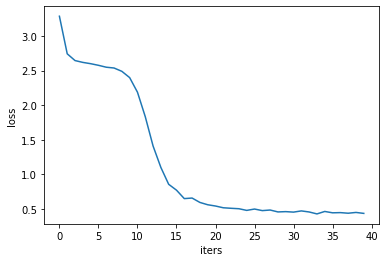

In [34]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

In [37]:
rand_input = get_random_seq() 
print("Input\n",rand_input)
print("Output")
print(generate_text(model, rand_input))

Input
 ainst my canker'd country with the spleen
Of all the under fiends. But if so be
Thou darest not this and that to prove more fortu
Output
ainst my canker'd country with the spleen
Of all the under fiends. But if so be
Thou darest not this and that to prove more fortut t ou t t t t t thin m t the t d che t t ce he t be fout t t t t t t in m t t m t f ce nd m ce t t 
